<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Константные-предсказания-по-скользящему-среднему" data-toc-modified-id="Константные-предсказания-по-скользящему-среднему-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Константные предсказания по скользящему среднему</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Заключение" data-toc-modified-id="Заключение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Заключение</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Цель проекта:** спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

**Требования заказчика:** Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**
1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

*Примечание:* Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
#Загрузка библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import warnings
import timeit
warnings.filterwarnings("ignore")

#Настройки визуализации: 
plt.rcParams.update({'font.size':14, 'figure.figsize':(8,4)})

In [2]:
#Загрузка данных, парсинг дат, изменение индекса:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
taxi.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


**Вывод:** данные - временной ряд, отражающий число заказов такси по временным отрезкам в 10 минут.

In [3]:
print('Проверка на монотонность:', taxi.index.is_monotonic)
print('Процент пропусков: {:.1%}'.format(taxi['num_orders'].isnull().sum()/len(taxi)))

Проверка на монотонность: True
Процент пропусков: 0.0%


**Вывод:** сортировка по индексу не требуется, пропуски отсутствуют.

In [4]:
#ресемплинг  данных с агрегацией по сумме заказов:
taxi = taxi.resample('1H').sum()
taxi.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12


**Вывод:** данные подготовлены.

## Анализ

Распределение по заказам такси:

In [5]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


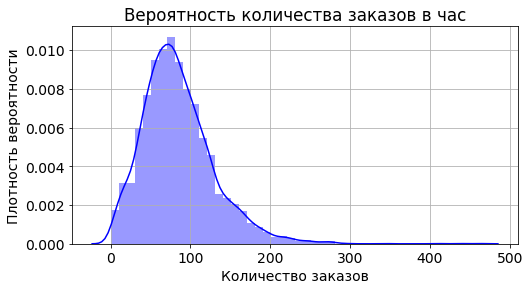

In [6]:
sns.distplot(taxi, bins=46, color='b')
plt.title('Вероятность количества заказов в час')
plt.xlabel('Количество заказов')
plt.ylabel('Плотность вероятности')
plt.grid()
plt.show()

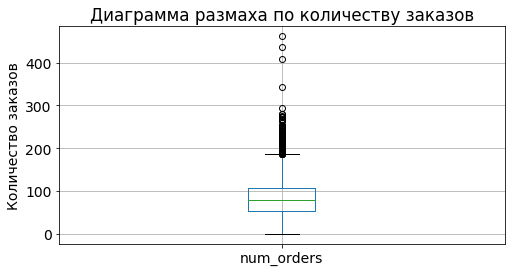

In [7]:
taxi.boxplot()
plt.title('Диаграмма размаха по количеству заказов')
plt.ylabel('Количество заказов')
plt.show()

**Выводы:** обнаружены выбросы, но в целом значения соответстуют реальности (вероятно, выбросы связаны с часами пика в аэропортах, когда в них прибывало наибольшее кол-во пассажиров).

Визуализируем данные:

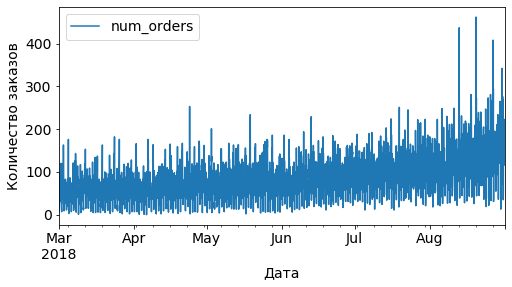

In [8]:
taxi.plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Данные почти не воспринимаются

Визуализируем скользящее среднее за неделю:

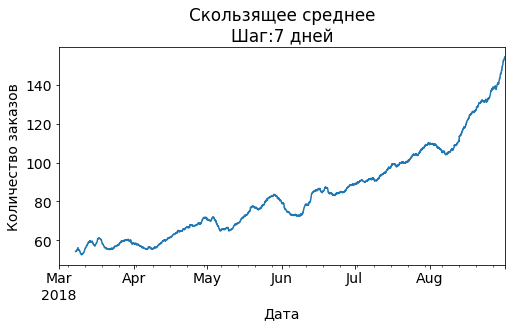

In [9]:
taxi.rolling(24*7).mean().plot(legend = False)
plt.title('Скользящее среднее\nШаг:7 дней')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

**Выводы:** за выделеенный период времени количество заказов такси в аэропортах растёт.

Визуализация тренда:

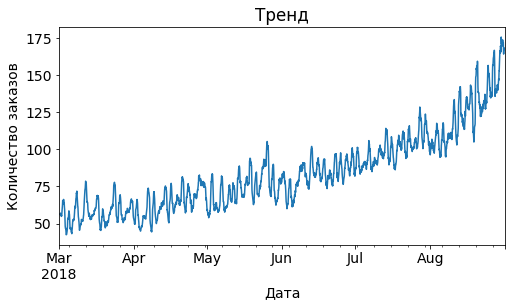

In [10]:
decomposed = seasonal_decompose(taxi)
decomposed.trend.plot(legend = False)
plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Визуализация суточных и недельных колебаний количества заказов от среднего:

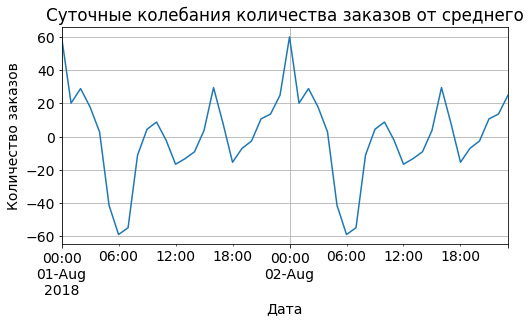

In [11]:
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(grid=True, legend = False)
plt.title('Суточные колебания количества заказов от среднего')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

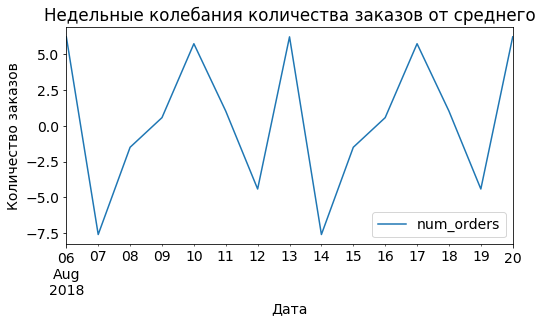

In [12]:
decomposed_days = seasonal_decompose(taxi.resample('1D').mean())
decomposed_days.seasonal['2018-08-06':'2018-08-20'].plot()
plt.title('Недельные колебания количества заказов от среднего')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

**Выводы:** 
- Тренд фактически повторяет график скользящего среднего;
- В течение суток заказы распределены неравномерно. Пик заказов - 0:00. Минимум заказов - 6:00. Периоды времени с повышенным спросом: 8:00 - 11:00 (рабочие поездки), 14:00 - 17:00 (обед), 19:00 - 04:00 (поездки домой); 
- В течение недели заказы распределены неравномерно. Пик заказов - понедельник, пятница (вероятно, это связано с командировками, выходными путешествиями и т.п. или возвращениями из командировок). Минимум заказов - вторник, воскресенье. Периоды времени с повышенным спросом: среда -  пятница.

## Обучение

Для обучения моделей создим признаки. Количество заказов зависит от скользящего среднего, от дня недели и времени суток. Дополнительными признаками зададим предыдущие значения ряда.

In [13]:
def features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
       
    for i in range(max_lag):
        name = 'lag_' + str(i+1)
        df[name] = df['num_orders'].shift(i+1)

    df['rolling_mean'] = df['num_orders'].rolling(rolling_mean_size).mean().shift(1)
    return df

Горизонт прогнозирования - 1 час. Цикличные изменения зафиксированы в рамках 1-х суток и 1-й недели, выбираем скользящее среднее за неделю, количичество отстающих значений задаём в пределах суток. 

In [14]:
taxi = features(taxi, 24, 24*7)

Разделим данные на выборки:

In [15]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Обучим модели на основе линейной регрессии, случайного леса и градиентного бустинга CatBoost.
Метрики качества: MAE, RMSE, sMAPE. 

In [16]:
def smape_score(y_true, y_pred):
    y_calc = abs(y_true - y_pred) / ((abs(y_true) + abs(y_pred)) / 2) * 100
    result = y_calc.sum() / len(y_true)
    return result

def testing(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    smape = smape_score(y_true, y_pred)
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('sMAPE:', smape)
    
    return mae, rmse, smape

### Линейная регрессия

In [17]:
%%time
start_time = timeit.default_timer()
model_linreg = LinearRegression()
model_linreg.fit(features_train, target_train)
linreg_train_time = timeit.default_timer() - start_time

CPU times: user 4.97 ms, sys: 14.3 ms, total: 19.2 ms
Wall time: 6.81 ms


In [18]:
%%time
start_time = timeit.default_timer()
linreg_res = model_linreg.predict(features_test)
linreg_mae, linreg_rmse, linreg_smape = testing(target_test, linreg_res)
linreg_predict_time = timeit.default_timer() - start_time

MAE: 33.02066651279493
RMSE: 44.713726562838694
sMAPE: 25.28784533826011
CPU times: user 7.59 ms, sys: 30.1 ms, total: 37.7 ms
Wall time: 6.61 ms


### Случайный лес

In [19]:
%%time
start_time = timeit.default_timer()
#(используем TimeSeriesSplit, чтобы не обучать модель на данных из будущего)
model_rfr = RandomForestRegressor(random_state=42)

params = {
    'n_estimators':[20, 50, 100],
    'max_depth':[10, 15, 20], 
    'min_samples_leaf':[2, 6, 10]
}

rfr_grid = GridSearchCV(estimator=model_rfr,
                        param_grid=params, 
                        cv=TimeSeriesSplit(n_splits=3).split(features_train), 
                        scoring='neg_mean_squared_error')
rfr_grid.fit(features_train, target_train)
rfr_train_time = timeit.default_timer() - start_time

CPU times: user 1min 42s, sys: 121 ms, total: 1min 42s
Wall time: 1min 44s


In [20]:
%%time
start_time = timeit.default_timer()
rfr_res = rfr_grid.predict(features_test)
rfr_mae, rfr_rmse, rfr_smape = testing(target_test, rfr_res)
rfr_predict_time = timeit.default_timer() - start_time

MAE: 30.565906286265022
RMSE: 41.10590919482626
sMAPE: 23.245172320404887
CPU times: user 18.7 ms, sys: 22 µs, total: 18.7 ms
Wall time: 16.3 ms


### CatBoost

In [21]:
%%time
start_time = timeit.default_timer()
model_cb = CatBoostRegressor(learning_rate=0.1,
                             early_stopping_rounds=50,
                             loss_function='RMSE',
                             random_state=42)
model_cb.fit(features_train, target_train, eval_set=(features_test, target_test), verbose=100)
cb_train_time = timeit.default_timer() - start_time

0:	learn: 36.8774649	test: 81.2816882	best: 81.2816882 (0)	total: 54ms	remaining: 53.9s
100:	learn: 19.2829323	test: 42.5839615	best: 42.5687960 (99)	total: 4.09s	remaining: 36.4s
200:	learn: 15.8865971	test: 40.6679678	best: 40.6679678 (200)	total: 8.2s	remaining: 32.6s
300:	learn: 13.5660741	test: 39.7610583	best: 39.7610583 (300)	total: 12.1s	remaining: 28.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 39.65385056
bestIteration = 327

Shrink model to first 328 iterations.
CPU times: user 13.2 s, sys: 1.68 s, total: 14.9 s
Wall time: 17.2 s


In [22]:
%%time
start_time = timeit.default_timer()
cb_res = model_cb.predict(features_test)
cb_mae, cb_rmse, cb_smape = testing(target_test, cb_res)
cb_predict_time = timeit.default_timer() - start_time

MAE: 29.482679524559785
RMSE: 39.65385055523195
sMAPE: 22.4859629944373
CPU times: user 8.32 ms, sys: 8.06 ms, total: 16.4 ms
Wall time: 11.8 ms


### Константные предсказания по скользящему среднему

In [23]:
dummy_rolling_mean = features_test['rolling_mean']
roll_mean_mae, roll_mean_rmse, roll_mean_smape = testing(target_test, dummy_rolling_mean)

MAE: 43.01478668390433
RMSE: 57.71743422219121
sMAPE: 32.751772011268706


## Тестирование

Сводная таблица результатов:

In [24]:
metrics = [
    [linreg_mae, linreg_rmse, linreg_smape, linreg_train_time, linreg_predict_time],
    [rfr_mae, rfr_rmse, rfr_smape, rfr_train_time, rfr_predict_time],
    [cb_mae, cb_rmse, cb_smape, cb_train_time, cb_predict_time],
    [roll_mean_mae, roll_mean_rmse, roll_mean_smape, None, None],
]
     
index = ['LinearRegression', 'RandomForest', 'CatBoostRegressor', 
         'Dummy_RollingMean']
columns = ['MAE', 'RMSE', 'sMAPE','Train_time','Predict_Time']
final = pd.DataFrame(metrics, index=index, columns=columns)
final.sort_values(by='RMSE')

,MAE,RMSE,sMAPE,Train_time,Predict_Time
CatBoostRegressor,29.482680,39.653851,22.485963,17.197142,0.011727
RandomForest,30.565906,41.105909,23.245172,104.522635,0.016291
LinearRegression,33.020667,44.713727,25.287845,0.006787,0.006584
Dummy_RollingMean,43.014787,57.717434,32.751772,NaN,NaN


**Выводы:** 
- Все алгоритмы машинного обучения удовлетворяют требованиям заказчика - RMSE < 48;
- Лучший результат - модель градиентного бустинга CatBoost, которая при этом быстрее всех предсказывает;
- Если заказчику важна скорость обучения модели (например, нужно обрабатывать разные данные), следует обратить внимание на модель линейной регрессии;

Графики предсказаний:

In [25]:
compare_table = target_test.to_frame()
compare_table['LinearRegression'] = linreg_res
compare_table['RandomForest'] =  rfr_res
compare_table['CatBoost'] =  cb_res

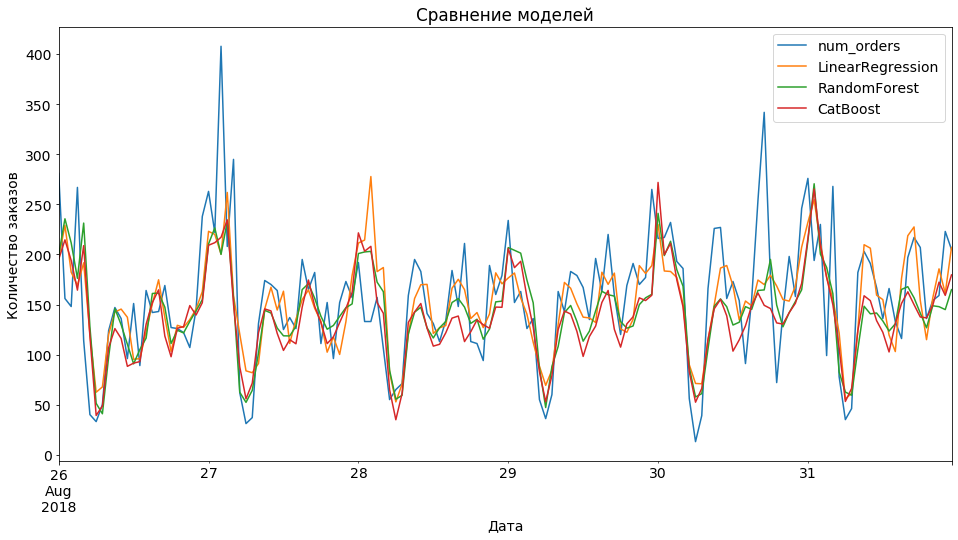

In [26]:
compare_table['2018-08-26':'2018-08-31'].plot(figsize=(16,8))
plt.title('Сравнение моделей')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

**Выводы:** Все модели неплохо прогнозируют ряд, хотя есть сильные всплески, просадки,случайные выбросы.

## Заключение

- Решена задача прогнозирования временного ряда;
- Выявлена циклическая зависимость заказов такси от дня недели и времени суток; 
- На основании исходных данных обучены и проанализированы модели машинного обучения для прогнозирования количества заказов в аэропортах на следующий час;  
- Все модели показывают качество существенно выше, чем предсказание по скользящему среднему, при этом удовлетворяют требованиям заказчика; 
- Лучший результат предсказаний у модели CatBoost, RMSE = 39.65. Самая простая модель - линейной регрессии - показала результат RMSE = 44.7. По скорости предсказаний лучшая модель - CatBoost. По скорости обучения - модель линейной регрессии.